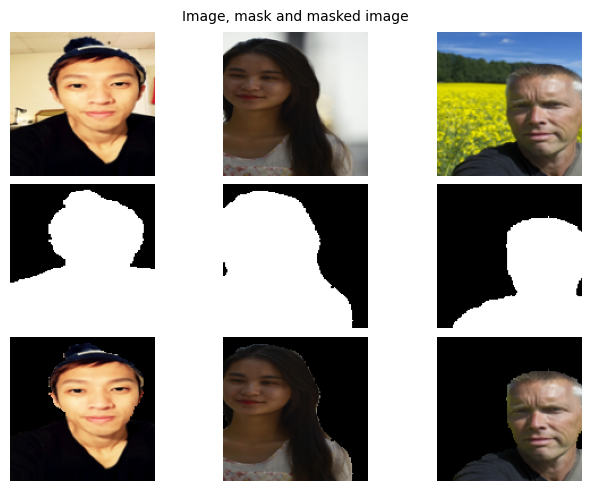

In [1]:
import os
import numpy as np
from akida_models import fetch_file

# Download validation set from Brainchip data server, it contains 10% of the original dataset
data_path = fetch_file(fname="val.tar.gz",
                       origin="https://data.brainchip.com/dataset-mirror/portrait128/val.tar.gz",
                       cache_subdir=os.path.join("datasets", "portrait128"),
                       extract=True)

data_dir = os.path.join(os.path.dirname(data_path), "val")
x_val = np.load(os.path.join(data_dir, "val_img.npy"))
y_val = np.load(os.path.join(data_dir, "val_msk.npy")).astype('uint8')
batch_size = 32
steps = x_val.shape[0] // 32

# Visualize some data
import matplotlib.pyplot as plt

id = np.random.randint(0, x_val.shape[0])

fig, axs = plt.subplots(3, 3, constrained_layout=True)
for col in range(3):
    axs[0, col].imshow(x_val[id + col] / 255.)
    axs[0, col].axis('off')
    axs[1, col].imshow(1 - y_val[id + col], cmap='Greys')
    axs[1, col].axis('off')
    axs[2, col].imshow(x_val[id + col] / 255. * y_val[id + col])
    axs[2, col].axis('off')

fig.suptitle('Image, mask and masked image', fontsize=10)
plt.show()

In [2]:
from akida_models.model_io import load_model

# Retrieve the model file from Brainchip data server
model_file = fetch_file(fname="akida_unet_portrait128.h5",
                        origin="https://data.brainchip.com/models/AkidaV2/akida_unet/akida_unet_portrait128.h5",
                        cache_subdir='models')

# Load the native Keras pre-trained model
model_keras = load_model(model_file)
model_keras.summary()

Model: "akida_unet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv_0 (Conv2D)             (None, 64, 64, 16)        432       
                                                                 
 conv_0/BN (BatchNormalizati  (None, 64, 64, 16)       64        
 on)                                                             
                                                                 
 conv_0/relu (ReLU)          (None, 64, 64, 16)        0         
                                                                 
 conv_1 (Conv2D)             (None, 64, 64, 32)        4608      
                                                        

In [3]:
from keras.metrics import BinaryIoU

# Compile the native Keras model (required to evaluate the metrics)
model_keras.compile(loss='binary_crossentropy', metrics=[BinaryIoU(), 'accuracy'])

# Check Keras model performance
_, biou, acc = model_keras.evaluate(x_val, y_val, steps=steps, verbose=0)

print(f"Keras binary IoU / pixel accuracy: {biou:.4f} / {100*acc:.2f}%")

Keras binary IoU / pixel accuracy: 0.9324 / 96.62%


In [4]:
from akida_models import akida_unet_portrait128_pretrained

# Load the pre-trained quantized model
model_quantized_keras = akida_unet_portrait128_pretrained()
model_quantized_keras.summary()

Model: "akida_unet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 rescaling (QuantizedRescali  (None, 128, 128, 3)      0         
 ng)                                                             
                                                                 
 conv_0 (QuantizedConv2D)    (None, 64, 64, 16)        448       
                                                                 
 conv_0/relu (QuantizedReLU)  (None, 64, 64, 16)       32        
                                                                 
 conv_1 (QuantizedConv2D)    (None, 64, 64, 32)        4640      
                                                                 
 conv_1/relu (QuantizedReLU)  (None, 64, 64, 32)       64        
                                                        

In [5]:
# Compile the quantized Keras model (required to evaluate the metrics)
model_quantized_keras.compile(loss='binary_crossentropy', metrics=[BinaryIoU(), 'accuracy'])

# Check Keras model performance
_, biou, acc = model_quantized_keras.evaluate(x_val, y_val, steps=steps, verbose=0)

print(f"Keras quantized binary IoU / pixel accuracy: {biou:.4f} / {100*acc:.2f}%")

Keras quantized binary IoU / pixel accuracy: 0.9319 / 96.59%


: 

In [ ]:
from cnn2snn import convert

# Convert the model
model_akida = convert(model_quantized_keras)
model_akida.summary()

In [ ]:
import tensorflow as tf

# Check Akida model performance
labels, pots = None, None

for s in range(steps):
    batch = x_val[s * batch_size: (s + 1) * batch_size, :]
    label_batch = y_val[s * batch_size: (s + 1) * batch_size, :]
    pots_batch = model_akida.predict(batch.astype('uint8'))

    if labels is None:
        labels = label_batch
        pots = pots_batch
    else:
        labels = np.concatenate((labels, label_batch))
        pots = np.concatenate((pots, pots_batch))
preds = tf.keras.activations.sigmoid(pots)

m_binary_iou = tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5)
m_binary_iou.update_state(labels, preds)
binary_iou = m_binary_iou.result().numpy()

m_accuracy = tf.keras.metrics.Accuracy()
m_accuracy.update_state(labels, preds > 0.5)
accuracy = m_accuracy.result().numpy()
print(f"Akida binary IoU / pixel accuracy: {binary_iou:.4f} / {100*accuracy:.2f}%")

# For non-regression purpose
assert binary_iou > 0.9

In [ ]:
import matplotlib.pyplot as plt

# Estimate age on a random single image and display Keras and Akida outputs
sample = np.expand_dims(x_val[id, :], 0)
keras_out = model_keras(sample)
akida_out = tf.keras.activations.sigmoid(model_akida.forward(sample.astype('uint8')))

fig, axs = plt.subplots(1, 3, constrained_layout=True)
axs[0].imshow(keras_out[0] * sample[0] / 255.)
axs[0].set_title('Keras segmentation', fontsize=10)
axs[0].axis('off')

axs[1].imshow(akida_out[0] * sample[0] / 255.)
axs[1].set_title('Akida segmentation', fontsize=10)
axs[1].axis('off')

axs[2].imshow(y_val[id] * sample[0] / 255.)
axs[2].set_title('Expected segmentation', fontsize=10)
axs[2].axis('off')

plt.show()